# Predicting the Occurrence of Oceanic Anoxic Events with Ensemble Machine-Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno

In [2]:
df = pd.read_excel('geochemical_dataset.xlsx', usecols = ['d13C_org', 'TOC', 'Mo', 'U', 'V','OAE2'])

In [3]:
df.dtypes

d13C_org    float64
TOC         float64
Mo          float64
U           float64
V           float64
OAE2          int64
dtype: object

In [4]:
df.describe()

,d13C_org,TOC,Mo,U,V,OAE2
count,679.000000,1592.000000,1291.000000,560.000000,1276.000000,1592.000000
mean,-25.058836,10.171059,48.595497,20.469313,6780.477564,0.503141
std,1.921713,7.211198,57.884019,33.898765,21158.207324,0.500147
min,-30.160000,0.000000,-2.610000,-0.300000,0.000000,0.000000
25%,-26.610000,4.785000,6.843900,2.837589,148.250000,0.000000
50%,-25.290000,8.975000,32.000000,6.327068,516.500000,1.000000
75%,-23.629166,14.210000,73.164300,17.800000,1544.750000,1.000000
max,-21.040000,30.430000,636.000000,162.900000,133203.883500,1.000000


In [5]:
df.isna().sum().sort_values()

TOC            0
OAE2           0
Mo           301
V            316
d13C_org     913
U           1032
dtype: int64

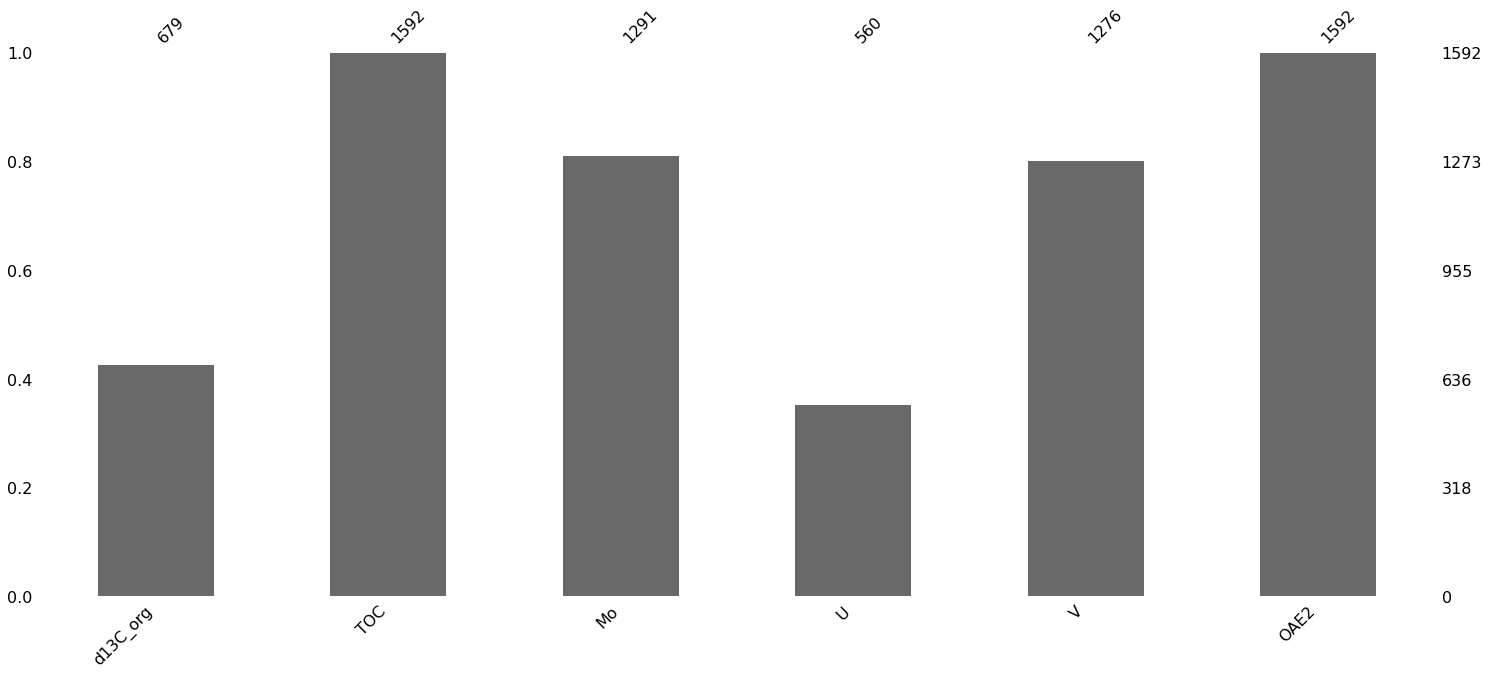

In [6]:
mno.bar(df);

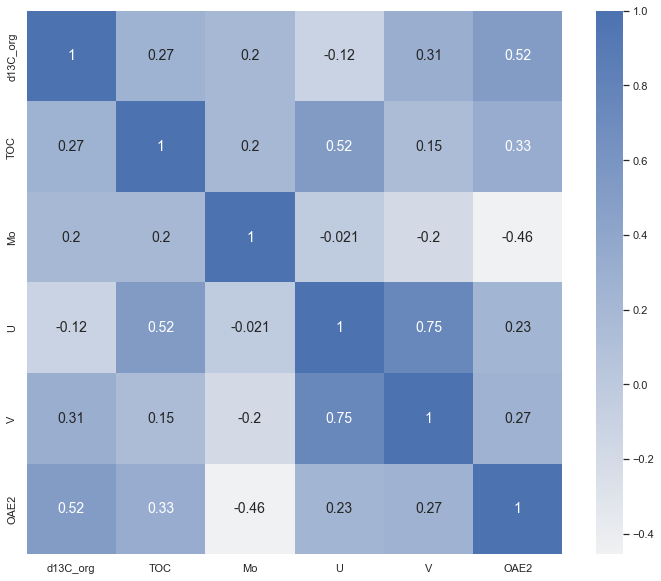

In [7]:
cor = df.corr()
sns.set(rc = {'figure.figsize' : (12,10)})
sns.heatmap(cor, cmap=sns.color_palette("light:b", as_cmap=True), annot = True, annot_kws={"size": 14});

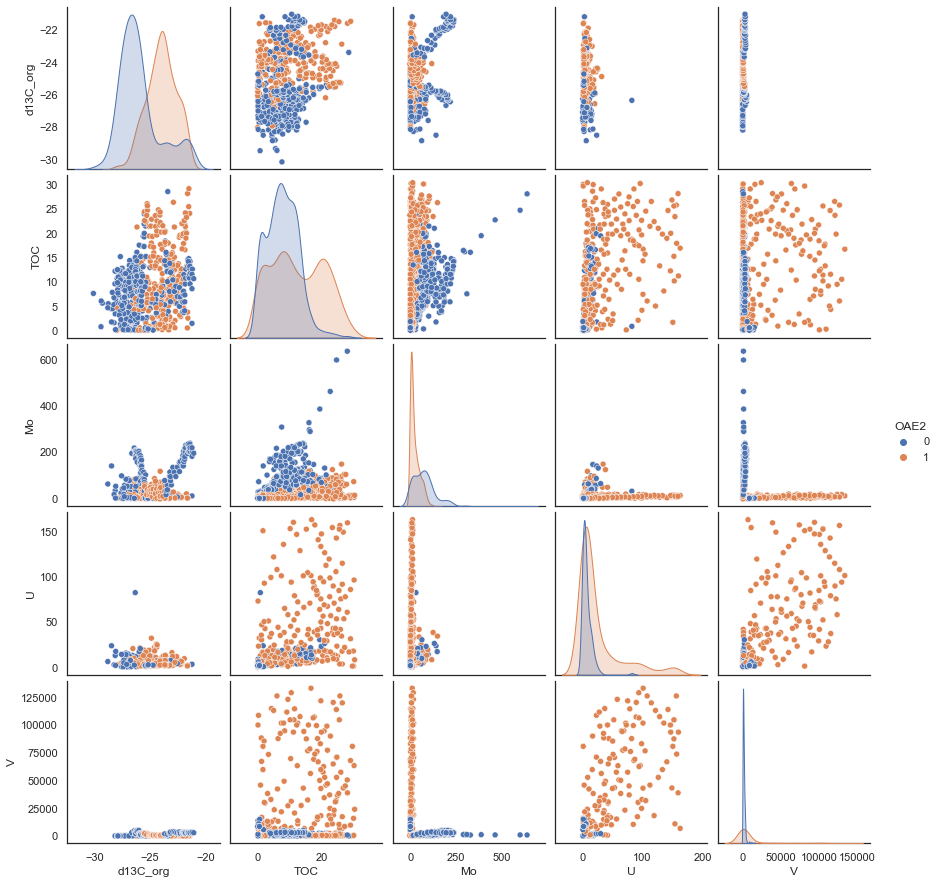

In [8]:
sns.set(style="white")
sns.pairplot(df, hue = 'OAE2');

# Data Imputation Using Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
def predict_NaN(col_name):
    df1 = df.copy()
    test_data = df[df[col_name].isnull()]
    df1=df1[['TOC', col_name]]
    df1.dropna(inplace=True)
    x_train = df1.drop(col_name,axis=1)
    y_train = df1[col_name]
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    x_test = test_data[['TOC']]
    y_pred = lr.predict(x_test)
    col_name_predicted = pd.Series(y_pred)
    col_name_predicted.index = df[col_name][df[col_name].isna()].index
    col_name_predicted = df[col_name].fillna(col_name_predicted)
    col_name_filled = pd.DataFrame({col_name:np.round(df[col_name],2), 
                                    col_name+' filled':np.round(col_name_predicted , 2)})
    df_filled = pd.DataFrame(col_name_filled)
    return(df_filled)

In [10]:
df_U = predict_NaN('U')
df_U.dropna(axis = 1,inplace=True)
df_V = predict_NaN('V')
df_V.dropna(axis = 1,inplace=True)
df_Mo = predict_NaN('Mo')
df_Mo.dropna(axis = 1,inplace=True)
df_d13C_org = predict_NaN('d13C_org')
df_d13C_org.dropna(axis = 1,inplace=True)

In [11]:
df_imputed = [df_Mo, df_U, df_V, df_d13C_org, df[['TOC']], df[['OAE2']]]
df_imputed = [df.set_index(df_U.index) for df in df_imputed]
df_imputed = df_imputed[0].join(df_imputed[1:])

In [12]:
df_imputed.describe()

,Mo filled,U filled,V filled,d13C_org filled,TOC,OAE2
count,1592.000000,1592.000000,1592.000000,1592.000000,1592.000000,1592.000000
mean,48.296652,24.793675,6412.666514,-24.927305,10.171059,0.503141
std,52.253317,23.229172,18968.447762,1.356776,7.211198,0.500147
min,-2.610000,-0.300000,0.000000,-30.160000,0.000000,0.000000
25%,10.290000,8.207500,215.712500,-25.710000,4.785000,0.000000
50%,40.900000,20.100000,852.500000,-24.955000,8.975000,1.000000
75%,65.405000,31.947500,3884.465000,-24.077500,14.210000,1.000000
max,636.000000,162.900000,133203.880000,-21.040000,30.430000,1.000000


In [13]:
df_imputed.isna().sum().sort_values()

Mo filled          0
U filled           0
V filled           0
d13C_org filled    0
TOC                0
OAE2               0
dtype: int64

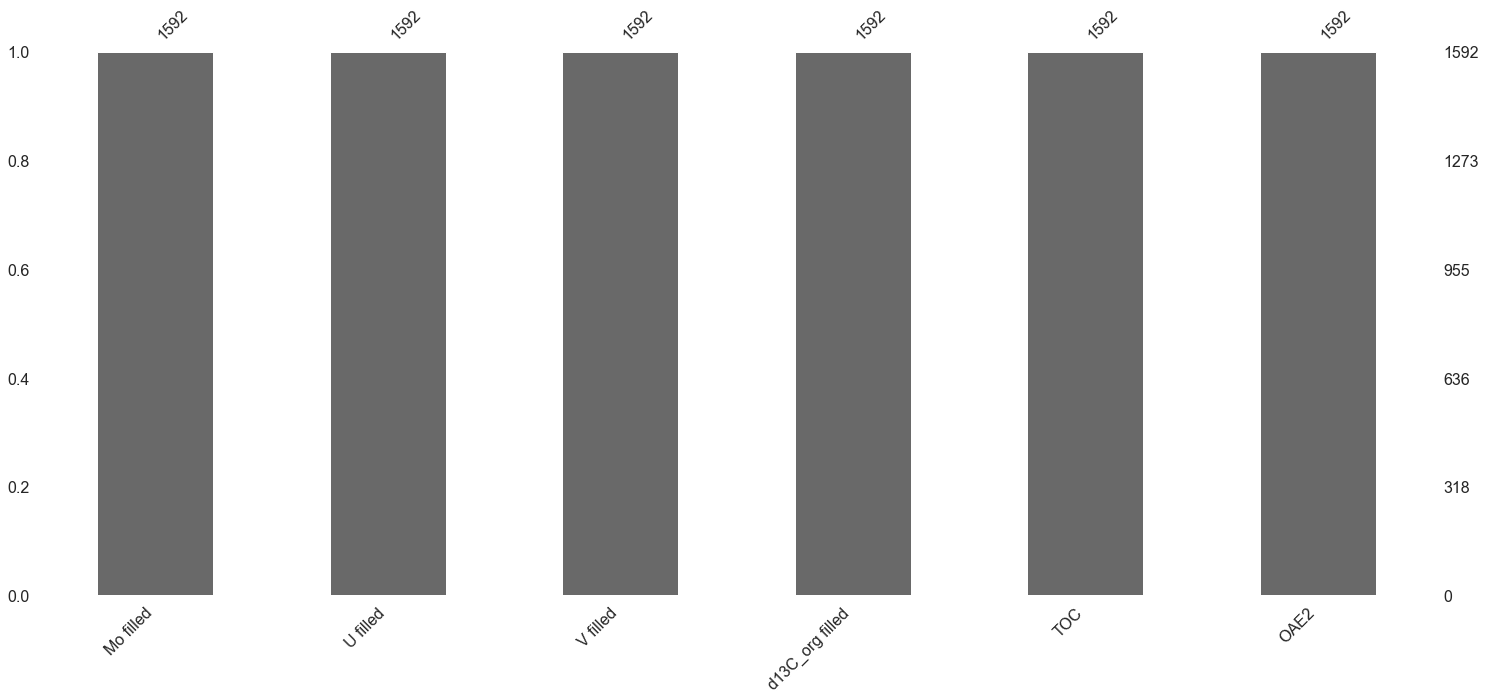

In [14]:
mno.bar(df_imputed);

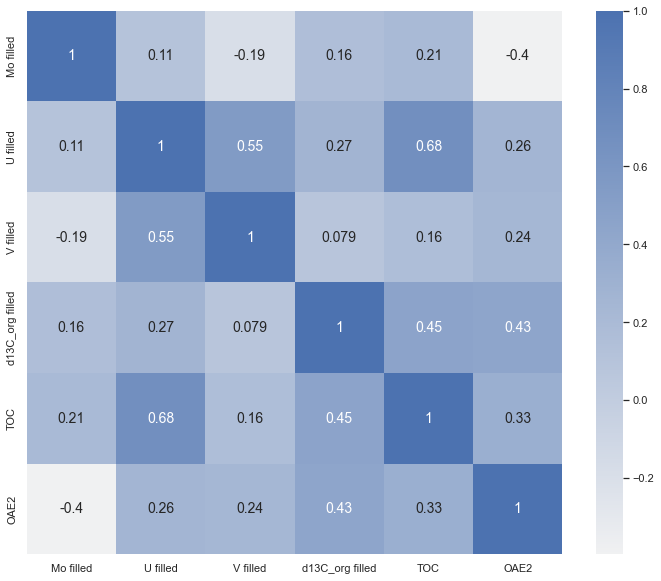

In [15]:
cor = df_imputed.corr()
sns.set(rc = {'figure.figsize' : (12,10)})
sns.heatmap(cor, cmap=sns.color_palette("light:b", as_cmap=True), annot = True, annot_kws={"size": 14});

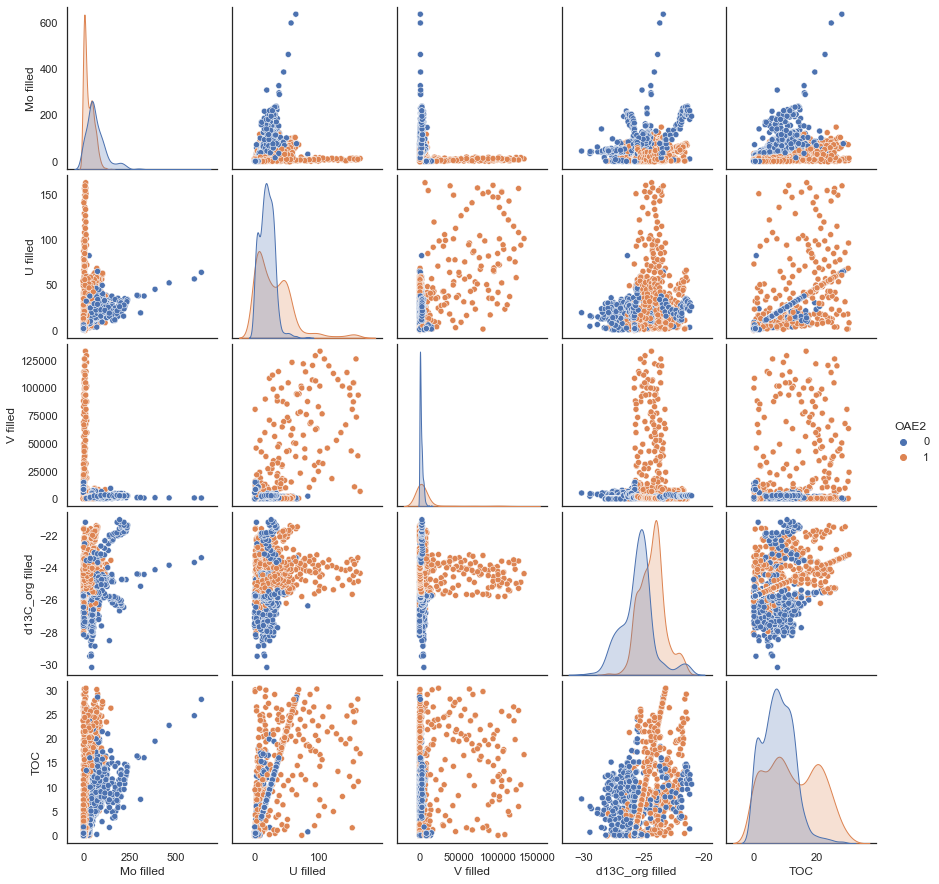

In [16]:
sns.set(style="white")
sns.pairplot(df_imputed, hue = 'OAE2');

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost
from sklearn.model_selection import train_test_split

# Train Test Split

In [18]:
train, test = train_test_split(df_imputed, test_size=0.2, random_state=19855)
x_train = train.drop(columns=["OAE2"])
y_train = train["OAE2"]
x_test = test.drop(columns=["OAE2"])
y_test = test["OAE2"]

## Random Forest

In [19]:
rf = RandomForestClassifier(n_estimators=30, max_depth=15, random_state=42)
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

0.9059561128526645

In [20]:
y_pred_rf = rf.predict(x_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf

array([[137,  16],
       [ 14, 152]], dtype=int64)

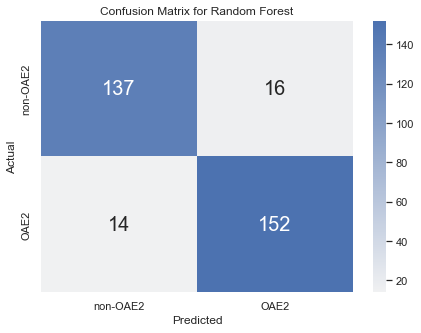

In [21]:
plt.figure(figsize = (7 ,5))
ax = sns.heatmap(cm_rf, annot=True, fmt='g', cmap = sns.color_palette("light:b", as_cmap=True), annot_kws={"size": 20})
ax.set_title('Confusion Matrix for Random Forest')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['non-OAE2', 'OAE2'])
ax.yaxis.set_ticklabels(['non-OAE2', 'OAE2'])
plt.show()

In [22]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       153
           1       0.90      0.92      0.91       166

    accuracy                           0.91       319
   macro avg       0.91      0.91      0.91       319
weighted avg       0.91      0.91      0.91       319



## Decision Tree

In [23]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt.score(x_test, y_test)

0.8652037617554859

In [24]:
y_pred_dt = dt.predict(x_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt

array([[135,  18],
       [ 25, 141]], dtype=int64)

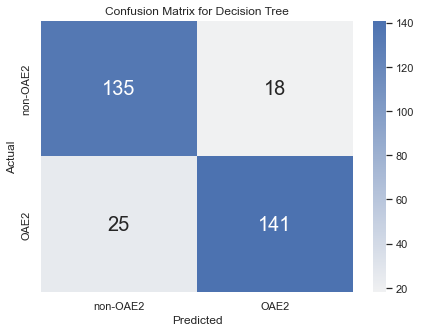

In [25]:
plt.figure(figsize = (7 ,5))
ax = sns.heatmap(cm_dt, annot=True, fmt='g', cmap = sns.color_palette("light:b", as_cmap=True), annot_kws={"size": 20})
ax.set_title('Confusion Matrix for Decision Tree')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['non-OAE2', 'OAE2'])
ax.yaxis.set_ticklabels(['non-OAE2', 'OAE2'])
plt.show()

In [26]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       153
           1       0.89      0.85      0.87       166

    accuracy                           0.87       319
   macro avg       0.87      0.87      0.87       319
weighted avg       0.87      0.87      0.87       319



## Logistic Regression

In [27]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr.score(x_test, y_test)

C:\Users\G202112990\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9028213166144201

In [28]:
y_pred_lr = lr.predict(x_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr

array([[141,  12],
       [ 19, 147]], dtype=int64)

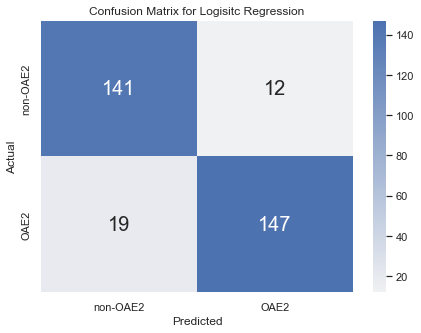

In [29]:
plt.figure(figsize = (7 ,5))
ax = sns.heatmap(cm_lr, annot=True, fmt='g', cmap = sns.color_palette("light:b", as_cmap=True), annot_kws={"size": 20})
ax.set_title('Confusion Matrix for Logisitc Regression')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['non-OAE2', 'OAE2'])
ax.yaxis.set_ticklabels(['non-OAE2', 'OAE2'])
plt.show()

In [30]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       153
           1       0.92      0.89      0.90       166

    accuracy                           0.90       319
   macro avg       0.90      0.90      0.90       319
weighted avg       0.90      0.90      0.90       319



## XGBoost

In [31]:
xg_cl=xgboost.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
xg_cl.fit(x_train, y_train)
xg_cl.score(x_test, y_test)

0.8934169278996865

In [32]:
y_pred_xg = xg_cl.predict(x_test)
cm_xg = confusion_matrix(y_test, y_pred_xg)
cm_xg

array([[133,  20],
       [ 14, 152]], dtype=int64)

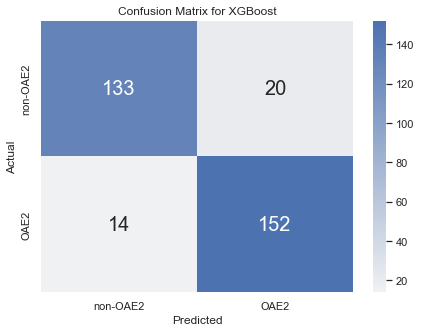

In [33]:
plt.figure(figsize = (7 ,5))
ax = sns.heatmap(cm_xg, annot=True, fmt='g', cmap = sns.color_palette("light:b", as_cmap=True), annot_kws={"size": 20})
ax.set_title('Confusion Matrix for XGBoost')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['non-OAE2', 'OAE2'])
ax.yaxis.set_ticklabels(['non-OAE2', 'OAE2'])
plt.show()

In [34]:
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       153
           1       0.88      0.92      0.90       166

    accuracy                           0.89       319
   macro avg       0.89      0.89      0.89       319
weighted avg       0.89      0.89      0.89       319



## Feature Importance

In [35]:
def feature_importance(model):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(x_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    plt.figure(1, figsize=(5, 5))
    plt.title("Feature importances")
    plt.bar(range(x_train.shape[1]), importances[indices],color="teal", align="center")
    plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=45)
    plt.xlim([-1, x_train.shape[1]])
    plt.show()

Feature ranking:
1. feature 3 (0.270144)
2. feature 0 (0.261153)
3. feature 1 (0.160609)
4. feature 2 (0.159405)
5. feature 4 (0.148689)


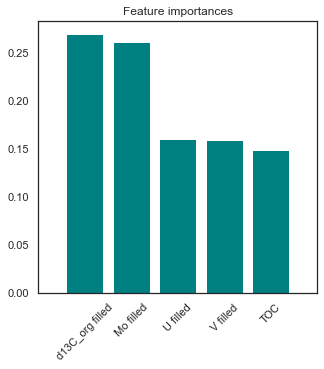

In [36]:
feature_importance(rf) #Random Forest

Feature ranking:
1. feature 3 (0.396174)
2. feature 0 (0.291991)
3. feature 2 (0.148499)
4. feature 4 (0.083884)
5. feature 1 (0.079452)


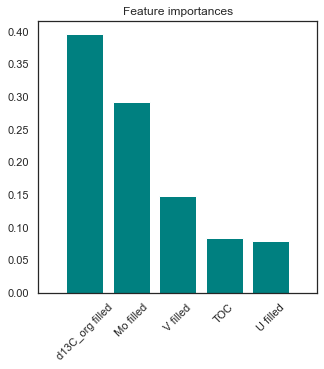

In [37]:
feature_importance(dt) #Decision Tree

Feature ranking:
1. feature 3 (0.426380)
2. feature 0 (0.265295)
3. feature 1 (0.112982)
4. feature 2 (0.103765)
5. feature 4 (0.091578)


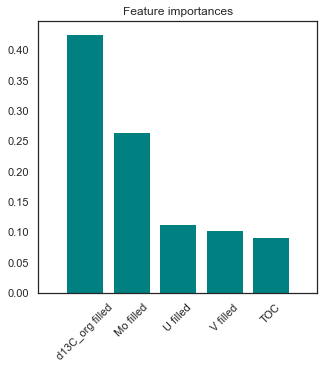

In [38]:
feature_importance(xg_cl) #XGBoost

C:\Users\G202112990\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


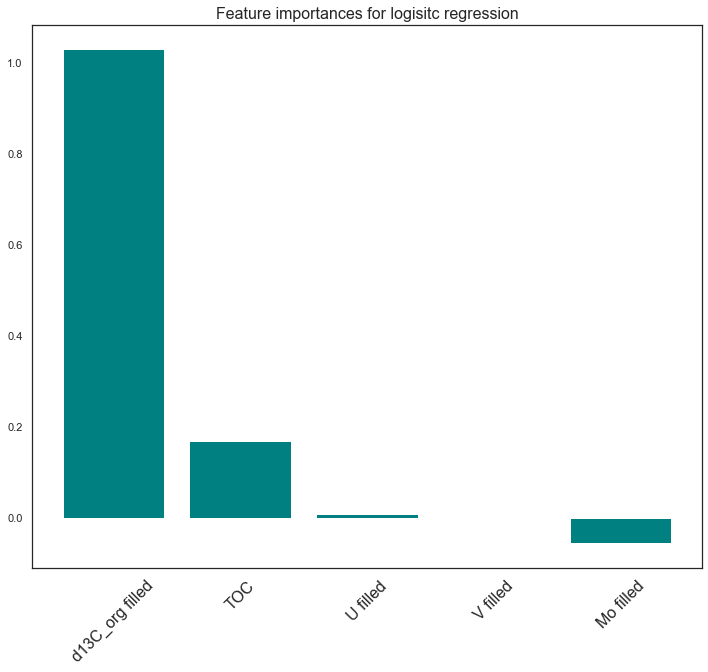

In [39]:
model = LogisticRegression()
model.fit(x_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color="teal")
plt.title('Feature importances for logisitc regression', size=16)
plt.xticks(size=16, rotation=45)
plt.show();

# Blind Test

In [40]:
df_loc = pd.read_excel('geochemical_dataset.xlsx', usecols = ['location'])
df_with_loc = df_imputed.join(df_loc, on = df_imputed.index)
df_with_loc.head()

,Mo filled,U filled,V filled,d13C_org filled,TOC,OAE2,location
0,34.05,4.30,2452.15,-29.47,0.76,0,La Luna Sea
1,33.92,4.10,2414.27,-27.19,0.67,0,La Luna Sea
2,41.41,14.88,4497.41,-29.34,5.62,0,La Luna Sea
3,42.07,15.84,4682.58,-29.45,6.06,0,La Luna Sea
4,44.44,19.24,5339.09,-30.16,7.62,0,La Luna Sea


In [41]:
location = 'ODP'
TEST = df_with_loc[df_with_loc['location'] == location]
TEST.drop(columns=['location'], inplace=True)
TRAIN = df_with_loc[df_with_loc['location'] != location]
TRAIN.drop(columns=['location'], inplace=True)

C:\Users\G202112990\AppData\Local\Temp\ipykernel_16704\4244401138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEST.drop(columns=['location'], inplace=True)
C:\Users\G202112990\AppData\Local\Temp\ipykernel_16704\4244401138.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TRAIN.drop(columns=['location'], inplace=True)


In [42]:
x_train = TRAIN.drop(columns=["OAE2"])
y_train = TRAIN["OAE2"]
x_test = TEST.drop(columns=["OAE2"])
y_test = TEST["OAE2"]

## Random Forest

In [43]:
rf = RandomForestClassifier(n_estimators=30, max_depth=15, random_state=42)
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

0.7305555555555555

In [44]:
y_pred_rf = rf.predict(x_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf

array([[354,  89],
       [105, 172]], dtype=int64)

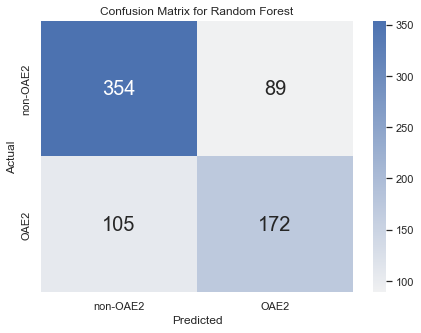

In [45]:
plt.figure(figsize = (7 ,5))
ax = sns.heatmap(cm_rf, annot=True, fmt='g', cmap = sns.color_palette("light:b", as_cmap=True), annot_kws={"size": 20})
ax.set_title('Confusion Matrix for Random Forest')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['non-OAE2', 'OAE2'])
ax.yaxis.set_ticklabels(['non-OAE2', 'OAE2'])
plt.show()

## Decision Tree

In [46]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt.score(x_test, y_test)

0.7472222222222222

In [47]:
y_pred_dt = dt.predict(x_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt

array([[364,  79],
       [103, 174]], dtype=int64)

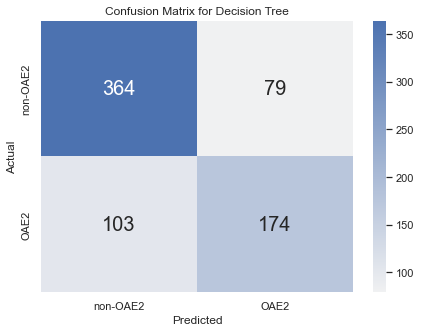

In [48]:
plt.figure(figsize = (7 ,5))
ax = sns.heatmap(cm_dt, annot=True, fmt='g', cmap = sns.color_palette("light:b", as_cmap=True), annot_kws={"size": 20})
ax.set_title('Confusion Matrix for Decision Tree')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['non-OAE2', 'OAE2'])
ax.yaxis.set_ticklabels(['non-OAE2', 'OAE2'])
plt.show()

## Logistic Regression

In [49]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr.score(x_test, y_test)

C:\Users\G202112990\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8736111111111111

In [50]:
y_pred_lr = lr.predict(x_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr

array([[439,   4],
       [ 87, 190]], dtype=int64)

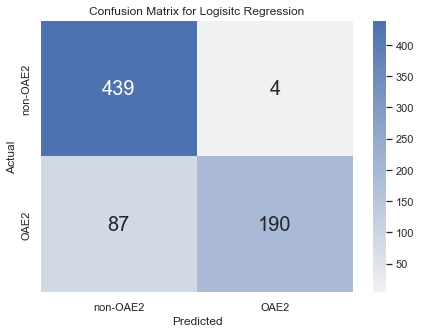

In [51]:
plt.figure(figsize = (7 ,5))
ax = sns.heatmap(cm_lr, annot=True, fmt='g', cmap = sns.color_palette("light:b", as_cmap=True), annot_kws={"size": 20})
ax.set_title('Confusion Matrix for Logisitc Regression')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['non-OAE2', 'OAE2'])
ax.yaxis.set_ticklabels(['non-OAE2', 'OAE2'])
plt.show()

## XGBoost

In [52]:
xg_cl=xgboost.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
xg_cl.fit(x_train, y_train)
xg_cl.score(x_test, y_test)

0.7277777777777777

In [53]:
y_pred_xg = xg_cl.predict(x_test)
cm_xg = confusion_matrix(y_test, y_pred_xg)
cm_xg

array([[359,  84],
       [112, 165]], dtype=int64)

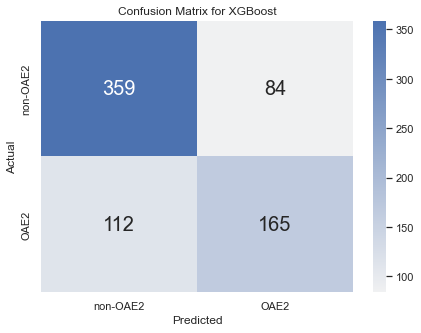

In [54]:
plt.figure(figsize = (7 ,5))
ax = sns.heatmap(cm_xg, annot=True, fmt='g', cmap = sns.color_palette("light:b", as_cmap=True), annot_kws={"size": 20})
ax.set_title('Confusion Matrix for XGBoost')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['non-OAE2', 'OAE2'])
ax.yaxis.set_ticklabels(['non-OAE2', 'OAE2'])
plt.show()

## Feature Importance

In [55]:
def feature_importance(model):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(x_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    plt.figure(1, figsize=(8, 5))
    plt.title("Feature importances")
    plt.bar(range(x_train.shape[1]), importances[indices],color="teal", yerr=std[indices], align="center")
    plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
    plt.xlim([-1, x_train.shape[1]])
    plt.show()

Feature ranking:
1. feature 3 (0.326202)
2. feature 0 (0.247945)
3. feature 2 (0.188805)
4. feature 4 (0.120711)
5. feature 1 (0.116337)


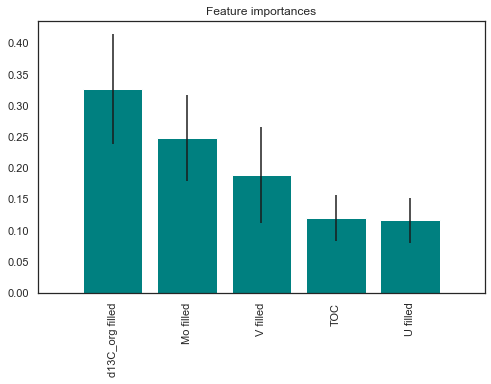

In [56]:
feature_importance(rf) #Random Forest

Feature ranking:
1. feature 3 (0.404825)
2. feature 0 (0.260597)
3. feature 2 (0.170304)
4. feature 4 (0.105078)
5. feature 1 (0.059196)


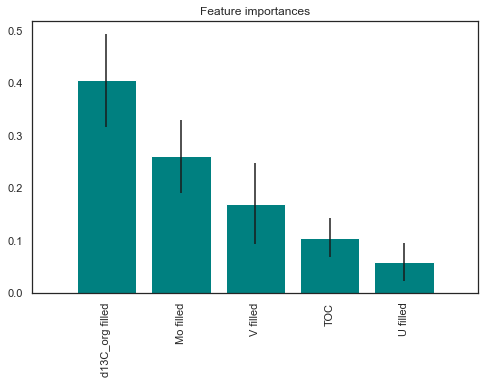

In [57]:
feature_importance(dt) #Decision Tree

Feature ranking:
1. feature 3 (0.403544)
2. feature 0 (0.258075)
3. feature 2 (0.146221)
4. feature 4 (0.099920)
5. feature 1 (0.092239)


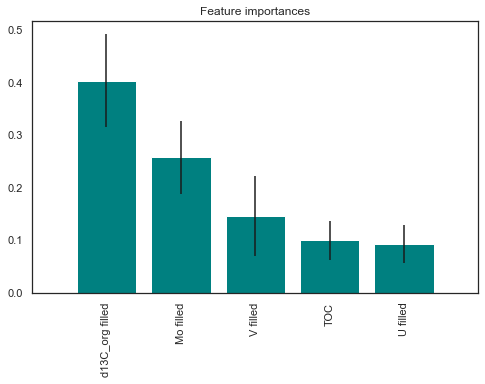

In [58]:
feature_importance(xg_cl) #XGBoost

C:\Users\G202112990\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


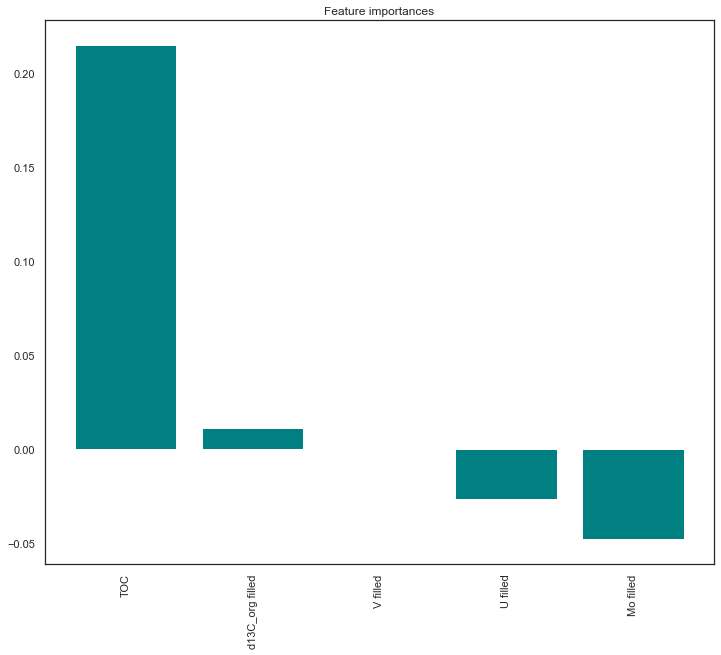

In [59]:
model = LogisticRegression()
model.fit(x_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color="teal")
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show();

## Blind Test Prediction Visualization

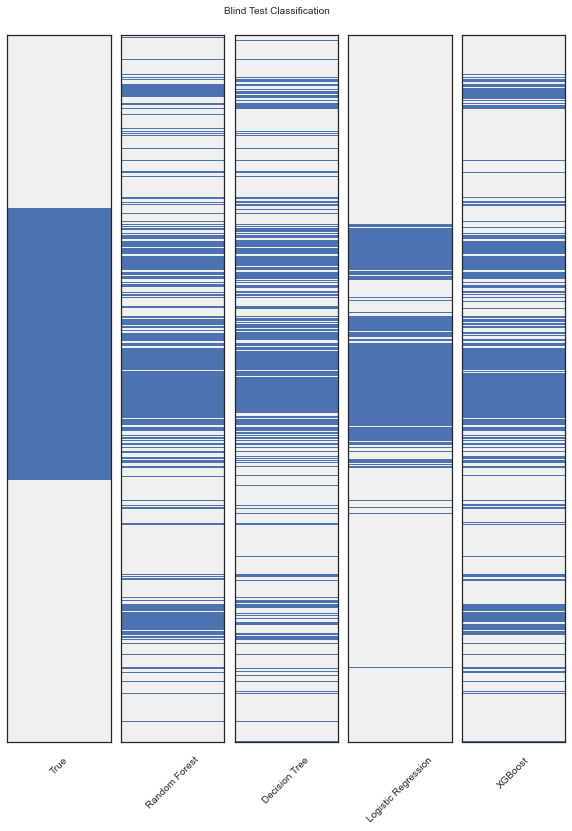

In [60]:
sns.set(style="white")
fig, axes = plt.subplots(figsize=(10,13))
ax1 = plt.subplot2grid((1,5), (0,0), rowspan = 1, colspan = 1)
ax2 = plt.subplot2grid((1,5), (0,1), rowspan = 1, colspan = 1)
ax3 = plt.subplot2grid((1,5), (0,2), rowspan = 1, colspan = 1)
ax4 = plt.subplot2grid((1,5), (0,3), rowspan = 1, colspan = 1)
ax5 = plt.subplot2grid((1,5), (0,4), rowspan = 1, colspan = 1)
ax1.imshow(pd.DataFrame(y_test), interpolation='none', aspect='auto',
                    cmap=sns.color_palette("light:b", as_cmap=True))
ax1.set_xlabel('True', fontsize=10,rotation=45)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax2.imshow(pd.DataFrame(y_pred_rf), interpolation='none', aspect='auto',
                    cmap=sns.color_palette("light:b", as_cmap=True))
ax2.set_xlabel('Random Forest', fontsize=10,rotation=45)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax3.imshow(pd.DataFrame(y_pred_dt), interpolation='none', aspect='auto',
                    cmap=sns.color_palette("light:b", as_cmap=True))
ax3.set_xlabel('Decision Tree', fontsize=10,rotation=45)
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax4.imshow(pd.DataFrame(y_pred_lr), interpolation='none', aspect='auto',
                    cmap=sns.color_palette("light:b", as_cmap=True))
ax4.set_xlabel('Logistic Regression', fontsize=10,rotation=45)
ax4.set_yticklabels([])
ax4.set_xticklabels([])
ax5.imshow(pd.DataFrame(y_pred_xg), interpolation='none', aspect='auto',
                    cmap=sns.color_palette("light:b", as_cmap=True))
ax5.set_xlabel('XGBoost', fontsize=10,rotation=45)
ax5.set_yticklabels([])
ax5.set_xticklabels([])
fig.subplots_adjust(wspace=0.1)
fig.suptitle('Blind Test Classification',fontsize=10,y=0.91);